## Basic RAG Pipeline

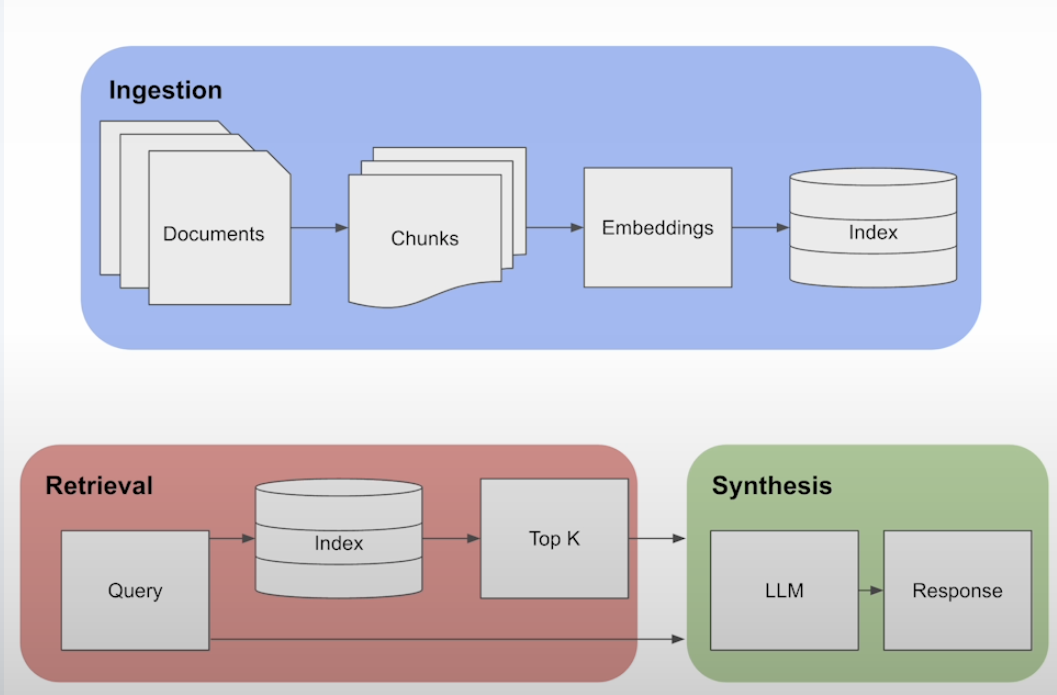

整個流程可以分為三個主要階段：

1. 藍色區塊：Ingestion (資料引入與處理)
這個階段是準備資料的過程，目的是將您擁有的知識庫（文件）轉換成一個可供快速檢索的格式。

- Documents (文件): 這是您的原始資料來源，可以是 PDF、網頁、Word 文件、資料庫內容等任何形式的文本資料。

- Chunks (區塊/片段): 由於大型語言模型有其處理長度的限制（稱為上下文視窗），因此需要將長文件切分成較小的、有意義的段落或區塊。這樣做有助於後續的檢索更精準。

- Embeddings (嵌入): 這是最關鍵的步驟之一。系統會使用一個「嵌入模型」(Embedding Model) 將每一個文字區塊轉換成一組數字向量（就像是數學上的座標）。這些向量能夠捕捉文字的「語義」，意思相近的文字區塊，其向量在空間中的位置也會比較接近。

- Index (索引): 系統將所有文字區塊的「嵌入向量」儲存在一個專門的資料庫中，通常是「向量資料庫」(Vector Database)。這個索引結構可以讓我們在後續階段極速地進行語義相似度的搜索。

**簡單來說，第一階段就是建立一個「語義知識庫」，把所有文件都變成機器可以理解和比對的數學形式。**

2. 紅色區塊：Retrieval (檢索)
當使用者提出問題時，這個階段會從知識庫中找出最相關的資訊。

- Query (查詢): 使用者輸入的問題或提示詞。

- Index (索引): 系統同樣會將使用者的「查詢」也轉換成一個嵌入向量。

- Top K (最相關的 K 個結果): 接著，系統會拿著這個「查詢向量」到前面建立好的「索引」中進行比對，找出與查詢向量在語義上最接近的 K 筆文件區塊（例如最接近的 3 筆或 5 筆）。

簡單來說，這個階段就像一個超級聰明的圖書館員，他能理解你問題的「意思」，而不僅僅是關鍵字，然後迅速地從書架上找出最相關的那幾頁資料。

3. 綠色區塊：Synthesis (生成)
這是最後產生回覆的階段。

- LLM (大型語言模型): 系統會將兩樣東西一起交給一個大型語言模型（例如 GPT-4）：

1. 原始的使用者查詢 (Query)
2. 前一步檢索到的相關文件區塊 (Top K)

- Response (回應): 大型語言模型會根據檢索到的這些上下文資料（文件區塊），來組織並生成一個完整、通順且精確的答案，然後回覆給使用者。

簡單來說，這個階段是讓一個博學的專家（LLM），參考剛剛圖書館員找來的精準資料，然後給你一個有憑有據的最終答案。

##### LlamaIndex
LlamaIndex 是一個開源的**「資料框架 (Data Framework)」，專門設計用來橋接您自有的資料與大型語言模型 (LLM)**。您可以把它想像成一個功能強大的「資料中介」，讓 LLM 能夠讀懂、查詢並利用那些模型本身在訓練時從未見過的私有或特定領域的資料。

它的核心目標是簡化和強化「檢索增強生成 (RAG)」應用的開發流程。LlamaIndex 不只是一個工具，更是一個完整的生態系統，提供從資料讀取、索引建立、資訊檢索到與 LLM 整合的全套解決方案。


```python
%pip install llama-index llama-index-llms-ollama llama-index-embeddings-ollama llama-index-vector-stores-postgres
```

## Basic RAG pipeline

In [2]:
from llama_index.core import VectorStoreIndex, ServiceContext
from llama_index.llms.ollama import Ollama
from llama_index.core import Settings
from llama_index.embeddings.ollama import OllamaEmbedding

Settings.embed_model = OllamaEmbedding(
    model_name="bge-m3",
    base_url="http://localhost:11434",
    ollama_additional_kwargs={"mirostat": 0},
)
Settings.llm = Ollama(model='llama3.2', base_url='http://localhost:11434',temperature=0.1, request_timeout=300.0)

In [3]:
from llama_index.core import SimpleDirectoryReader
documents = SimpleDirectoryReader(
    input_files=["../../Glossary _ Kubernetes.pdf"]
).load_data()

In [4]:
documents[0]

Document(id_='3a08ab1c-9d90-4254-8586-0587f47280de', embedding=None, metadata={'page_label': '1', 'file_name': 'Glossary _ Kubernetes.pdf', 'file_path': '../../Glossary _ Kubernetes.pdf', 'file_type': 'application/pdf', 'file_size': 525369, 'creation_date': '2025-07-05', 'last_modified_date': '2025-07-05'}, excluded_embed_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], excluded_llm_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], relationships={}, metadata_template='{key}: {value}', metadata_separator='\n', text_resource=MediaResource(embeddings=None, data=None, text='Architecture Community Core Object Extension Fundamental Networking\nOperation Security Storage Tool User Type Workload Select all\nDeselect all\nFilter terms according to their tags\nRelevant for a first-time user of Kubernetes.\nGlossary\nThis glossary is intended to be a comprehensive, 

[llamaindex | postgres | vector_stores](https://docs.llamaindex.ai/en/stable/examples/vector_stores/postgres/)

In [5]:
from llama_index.vector_stores.postgres import PGVectorStore
vector_store = PGVectorStore.from_params(
    database="llama_vector",
    host="localhost",
    password="123456",
    port='5433',
    user="admin",
    table_name="llama_vector",
    embed_dim=1024,  # openai embedding dimension
    # hnsw_kwargs={
    #     "hnsw_m": 16,
    #     "hnsw_ef_construction": 64,
    #     "hnsw_ef_search": 40,
    #     "hnsw_dist_method": "vector_cosine_ops",
    # },
)

In [6]:
from llama_index.core import StorageContext
storage_context = StorageContext.from_defaults(vector_store=vector_store)
index = VectorStoreIndex.from_documents(
    documents, storage_context=storage_context, show_progress=True
)

Parsing nodes:   0%|          | 0/11 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/11 [00:00<?, ?it/s]

In [7]:
query_engine = index.as_query_engine()

In [8]:
response = query_engine.query(
    "What is Deployment?"
) # 檢索 + 合成
print(str(response))

A Deployment in Kubernetes is an API object that manages a replicated application, typically by running Pods with no local state.


## Evaluation setup using TruLens

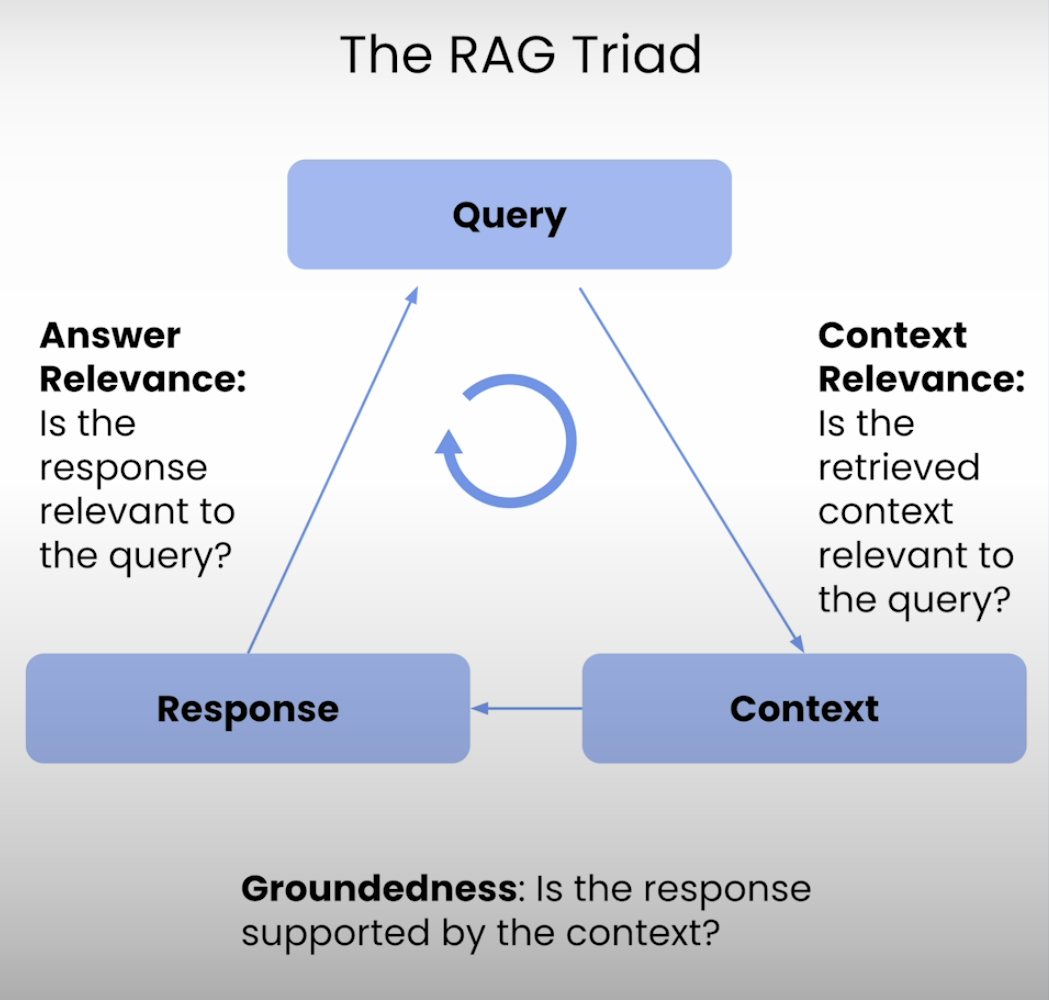

這張圖「The RAG Triad」（RAG 三元組合或 RAG 三要素）非常重要，它說明了評估一個「檢索增強生成」(RAG) 系統品質的三個核心維度。

簡單來說，它告訴我們，一個好的 RAG 系統不只是能「回答問題」而已，還必須確保其運作流程中的每一步都是可靠且準確的。這三個要素形成一個閉環，幫助開發者診斷和優化系統的表現。

以下是這三個核心要素的詳細解釋：

1. Context Relevance (上下文相關性)
它問的問題是：「系統檢索出來的『上下文』(Context) 與使用者原始的『查詢』(Query) 是否相關？」

評估的對象：檢索 (Retrieval) 階段的品質。

為什麼重要：這是整個 RAG 流程的基礎。如果第一步就找錯了資料（例如，你問蘋果電腦，系統卻找來種植蘋果樹的資料），那麼即使後面的大型語言模型（LLM）再聰明，也無法產生出正確的答案。這就是所謂的「垃圾進，垃圾出」(Garbage In, Garbage Out)。如果這個指標分數低，代表您需要優化您的文件切塊策略、嵌入模型或檢索演算法。

2. Groundedness (有據性 / 忠實度)
它問的問題是：「最終的『回應』(Response) 是否完全基於所提供的『上下文』(Context)？」

評估的對象：生成 (Generation) 階段的忠實度，也就是偵測幻覺 (Hallucination) 的程度。

為什麼重要：這個指標用來確保 LLM 不會「自由發揮」或「憑空捏造」答案。一個可靠的系統，其回答的每一句話都應該能在檢索到的上下文中找到依據。如果上下文說「產品有銀色和太空灰」，但 LLM 的回答卻是「產品有銀色、太空灰和金色」，那麼「金色」這個資訊就是無中生有，這個指標的分數就會降低。高「有據性」是建立使用者信任的關鍵。

3. Answer Relevance (答案相關性)
它問的問題是：「最終的『回應』(Response) 是否直接且有效地回答了使用者的『查詢』(Query)？」

評估的對象：整個系統的最終產出品質與使用者體驗。

為什麼重要：有時候，即使檢索到的上下文是相關的，且回答也完全基於上下文，但最終的答案可能還是答非所問或不夠直接。例如，你問「這台筆電多少錢？」，系統檢索到了正確的產品頁面（上下文相關性高），也根據頁面內容回答「這台筆電配備了最新的 M4 晶片」（有據性高），但這個答案卻沒有回答到最核心的「價格」問題，因此「答案相關性」就很低。

**總結**
「RAG 三元組合」提供了一個完整的框架來分析 RAG 系統的健康狀況：

1. Context Relevance 確保你找到了對的資料。

2. Groundedness 確保 LLM 誠實地使用這些資料。

3. Answer Relevance 確保最終的答案確實解決了使用者的問題。

當一個 RAG 系統的表現不如預期時，開發者可以透過評估這三個指標，快速定位問題是出在「檢索」階段還是「生成」階段，從而進行精準的優化。

TruLens 就是一個將「RAG 三元組合」理論付諸實踐的開源工具。

它是一個專門用於評估、追蹤和深入觀察 (Observability) 大型語言模型（LLM）應用的工具，尤其擅長評估 RAG 系統。

#### 為什麼需要 TruLens？
當您用 LlamaIndex 或 LangChain 建立了一個 RAG 應用後，您會立刻遇到一系列問題：

我怎麼知道我的系統回答得好不好？

當我修改了提示詞 (Prompt)、更換了嵌入模型、或調整了文件切塊大小後，系統是變好了還是變差了？

我要如何量化「幻覺」(Hallucination) 或「答案不相關」的程度？

當某個回答出錯時，問題到底出在「檢索」階段還是「生成」階段？

單純靠人工去測試幾十、幾百個問題是非常耗時且不客觀的。TruLens 的目的就是為了解決以上所有問題，讓評估過程自動化、客觀化、且可追溯。

#### TruLens 的核心功能
TruLens 的核心功能與「RAG 三元組合」完美對應：

實現 RAG 三元組合的自動化評估
1. TruLens 內建了可以直接使用的回饋函式 (Feedback Functions) 來幫您計算 RAG 三元組合的分數。它的運作方式通常是「以子之矛，攻子之盾」，也就是使用一個強大的 LLM（如 GPT-4）來當作評審。

- 上下文相關性 (Context Relevance)：TruLens 會把「查詢」和「檢索到的上下文」一起交給評審 LLM，問它：「這份上下文跟這個查詢相關嗎？」

- 有據性 (Groundedness)：TruLens 會把「上下文」和「最終的回應」交給評審 LLM，問它：「這個回應中的每一句話，都能在提供的上下文中找到證據支持嗎？」

- 答案相關性 (Answer Relevance)：TruLens 會把「查詢」和「最終的回應」交給評審 LLM，問它：「這個回應是否完整且直接地回答了這個查詢？」

2. 實驗追蹤與視覺化儀表板 (Dashboard)

光有分數還不夠，您需要追蹤和比較。TruLens 會記錄您應用程式的每一次互動（查詢、上下文、回應）以及對應的三個評估分數。

- 它提供一個網頁版的儀表板，您可以在上面看到所有歷史紀錄。

- 可以輕易地比較不同版本（例如，使用不同提示詞）的應用，看看哪個版本的平均分數更高。

- 當某個版本出現分數下降時，您可以立刻發現「效能衰退」(Regression)。

3.深入觀察與可解釋性 (Explainability)

儀表板不僅顯示分數，還能讓您深入到每一次互動的細節中。您可以清楚地看到：

- 傳送給 LLM 的完整提示詞 (Prompt) 是什麼樣子。

- 系統從向量資料庫中檢索出的原始文件區塊 (Context) 有哪些。

- LLM 生成的最終回應 (Response) 是什麼。

這個「完整的調用鏈」讓除錯變得非常容易，您可以一目了然地知道問題出在哪個環節。

#### 簡單的工作流程

在 LlamaIndex 或 LangChain 的程式碼中，您通常只需要：

用 TruLens 的包裝器 (Wrapper) 把您的 RAG 應用包起來。

設定您想要追蹤的評估指標（例如，RAG 三元組合）。

正常執行您的應用程式。

啟動 TruLens 儀表板，開始分析結果。

**結論**

如果您說 LlamaIndex 是用來「建造」RAG 應用的工具，那麼 TruLens 就是用來「品管和維護」這個應用的工具。它是一個強大的品管儀器，幫助開發者建立更可靠、更值得信賴的 LLM 應用，確保系統不是一個黑盒子，而是可評估、可追蹤、可改進的。


[aws | blog | automated-rag-project-assessment-testing-using-trulens](https://aws.amazon.com/cn/blogs/china/automated-rag-project-assessment-testing-using-trulens/)

```python
pip install trulens trulens-providers-litellm litellm trulens-apps-llamaindex
```

In [12]:
eval_questions = []
with open('eval_questions.txt', 'r') as file:
    for line in file:
        # Remove newline character and convert to integer
        item = line.strip()
        print(item)
        eval_questions.append(item)

What is Deployment ?
What is StatefulSet ?
What is the difference between statefulset and deployment?
What is a worker machine in Kubernetes ?
How to install Kubernetes and setting cluster ?
How to Scheduler Pod ?


In [13]:
new_question = "How about Kubernetes?"
eval_questions.append(new_question)

In [14]:
from trulens.core import TruSession
session = TruSession()

session.reset_database()

/home/itachi/.local/lib/python3.11/site-packages/munch/__init__.py:24: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


🦑 Initialized with db url sqlite:///default.sqlite .
🛑 Secret keys may be written to the database. See the `database_redact_keys` option of `TruSession` to prevent this.


Updating app_name and app_version in apps table: 0it [00:00, ?it/s]
Updating app_id in records table: 0it [00:00, ?it/s]
Updating app_json in apps table: 0it [00:00, ?it/s]


In [ ]:
from utils import RagExample
rag = RagExample(query_engine)

tru_recorder = rag.get_prebuilt_trulens_recorder(query_engine,
                                             app_id="Direct Query Engine")

with tru_recorder as recording:
    for question in eval_questions:
        response = query_engine.query(question)

✅ In Answer Relevance, input question will be set to __record__.main_input or `Select.RecordInput` .
✅ In Answer Relevance, input context will be set to __record__.main_output or `Select.RecordOutput` .
✅ In Context Relevance, input question will be set to __record__.main_input or `Select.RecordInput` .
✅ In Context Relevance, input context will be set to __record__.calls[-1].rets.source_nodes[:].node.text .
✅ In Groundedness, input source will be set to __record__.calls[-1].rets.source_nodes[:].node.text.collect() .
✅ In Groundedness, input statement will be set to __record__.main_output or `Select.RecordOutput` .
instrumenting <class 'llama_index.embeddings.ollama.base.OllamaEmbedding'> for base <class 'llama_index.embeddings.ollama.base.OllamaEmbedding'>
instrumenting <class 'llama_index.embeddings.ollama.base.OllamaEmbedding'> for base <class 'llama_index.core.base.embeddings.base.BaseEmbedding'>
instrumenting <class 'llama_index.embeddings.ollama.base.OllamaEmbedding'> for base <c

/home/itachi/.local/lib/python3.11/site-packages/trulens/feedback/llm_provider.py:1798: UserWarning: Failed to process and remove trivial statements. Proceeding with all statements.
  warnings.warn(


/home/itachi/.local/lib/python3.11/site-packages/trulens/feedback/llm_provider.py:1798: UserWarning: Failed to process and remove trivial statements. Proceeding with all statements.
  warnings.warn(


In [16]:
records, feedback = session.get_records_and_feedback(app_ids=[])

In [17]:
session.get_leaderboard(app_ids=[])

,,Answer Relevance,Groundedness,latency,total_cost
app_name,app_version,,,,
Direct Query Engine,pre_base,0.5,0.833333,40.232966,0.0


In [18]:
records.head()

,app_name,app_version,app_id,app_json,type,record_id,input,output,tags,record_json,...,Answer Relevance,Groundedness,Context Relevance_calls,Groundedness_calls,Context Relevance feedback cost in USD,Groundedness feedback cost in USD,latency,total_tokens,total_cost,cost_currency
0,Direct Query Engine,pre_base,app_hash_26429b49db96522491dc262851eddd7f,"{'tru_class_info': {'name': 'TruLlama', 'modul...",RetrieverQueryEngine(llama_index.core.query_en...,record_hash_5188bcf9978e755eaff964d9e38a7fdb,How about Kubernetes?,A comprehensive glossary of Kubernetes termino...,-,{'record_id': 'record_hash_5188bcf9978e755eaff...,...,NaN,NaN,NaN,NaN,NaN,NaN,40.938919,0,0.0,USD
1,Direct Query Engine,pre_base,app_hash_26429b49db96522491dc262851eddd7f,"{'tru_class_info': {'name': 'TruLlama', 'modul...",RetrieverQueryEngine(llama_index.core.query_en...,record_hash_fd97faa90e13cf99fa54e2c70d79f780,How to Scheduler Pod ?,The scheduler determines which Pods should be ...,-,{'record_id': 'record_hash_fd97faa90e13cf99fa5...,...,NaN,NaN,NaN,NaN,NaN,NaN,40.853575,0,0.0,USD
2,Direct Query Engine,pre_base,app_hash_26429b49db96522491dc262851eddd7f,"{'tru_class_info': {'name': 'TruLlama', 'modul...",RetrieverQueryEngine(llama_index.core.query_en...,record_hash_91ebbb3cc1e238aa99d4886f9a1e58f3,How to install Kubernetes and setting cluster ?,"To install Kubernetes and set up a cluster, yo...",-,{'record_id': 'record_hash_91ebbb3cc1e238aa99d...,...,0.666667,0.666667,[],[{'args': {'source': ['Architecture Community ...,0.0,0.0,57.978927,0,0.0,USD
3,Direct Query Engine,pre_base,app_hash_26429b49db96522491dc262851eddd7f,"{'tru_class_info': {'name': 'TruLlama', 'modul...",RetrieverQueryEngine(llama_index.core.query_en...,record_hash_301d764f9017f94feef3ec3978f3bc95,What is a worker machine in Kubernetes ?,A node is a worker machine in Kubernetes.,-,{'record_id': 'record_hash_301d764f9017f94feef...,...,0.333333,1.000000,[],[{'args': {'source': ['LimitRange\nProvides co...,0.0,0.0,37.047289,0,0.0,USD
4,Direct Query Engine,pre_base,app_hash_26429b49db96522491dc262851eddd7f,"{'tru_class_info': {'name': 'TruLlama', 'modul...",RetrieverQueryEngine(llama_index.core.query_en...,record_hash_69cb8b3066d770a093e3bb1a04bb43dc,What is the difference between statefulset and...,StatefulSets manage a set of Pods that maintai...,-,{'record_id': 'record_hash_69cb8b3066d770a093e...,...,NaN,0.500000,[],[{'args': {'source': ['Spec\nDefines how each ...,0.0,0.0,41.829029,0,0.0,USD


In [19]:
records.to_json(path_or_buf="basic_rag.json", indent=2)

In [20]:
# from trulens.dashboard import run_dashboard

# run_dashboard(session, port=8502, address="localhost")

In [21]:
# from trulens.dashboard import stop_dashboard
# stop_dashboard(session)

## Advanced RAG pipeline

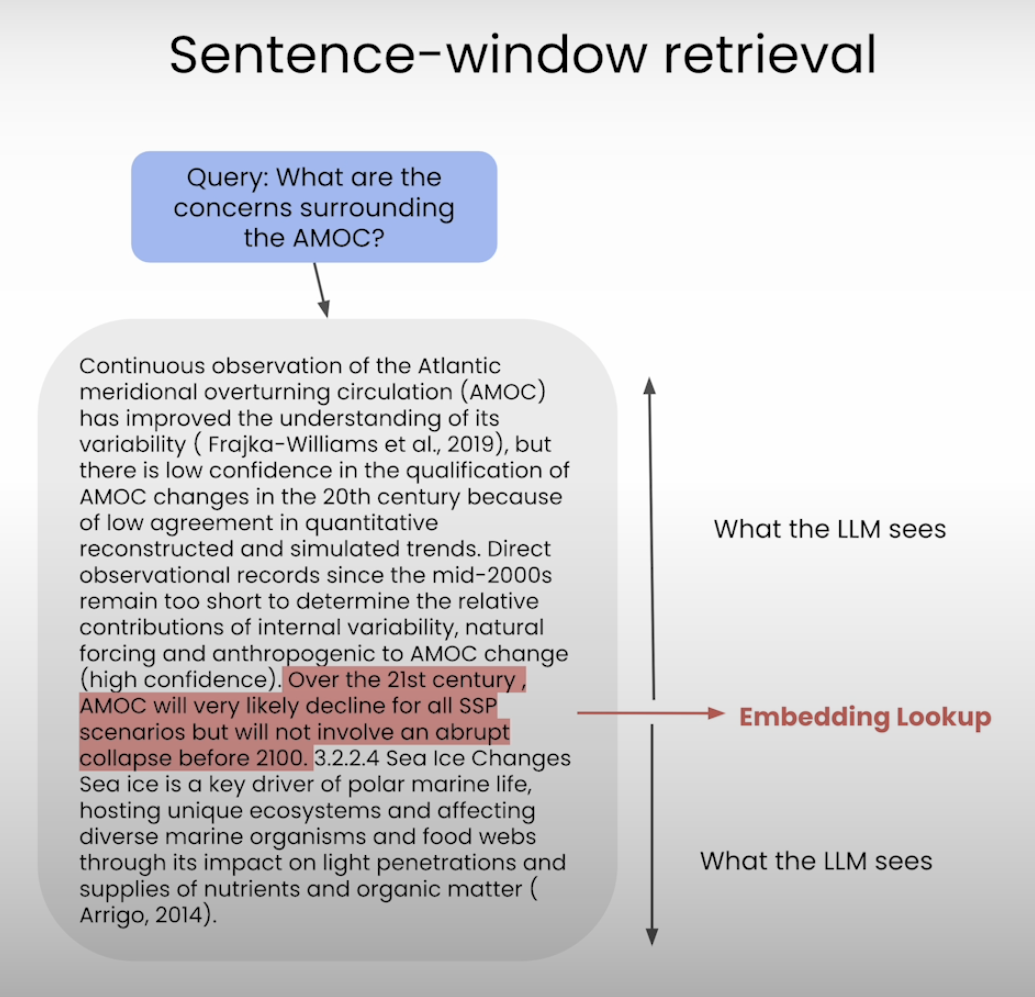


當使用者提出一個問題 (Query) 時，AI 系統如何從一份長文件中，精準地找出最相關的資訊片段，並提供足夠的上下文給大型語言模型 (LLM)，以便生成一個高品質的答案。

這整個流程是「檢索增強生成 (Retrieval-Augmented Generation, RAG)」架構中的關鍵一步。


**各個組件解析**

1. 查詢 (Query)

- 圖中文字: Query: What are the concerns surrounding the AMOC?
- 作用: 這是整個流程的起點，代表使用者的提問。系統的目標就是為這個問題在文件中找到最相關的答案。

2. 文本區塊 (The Document)

- 內容: 這是一段關於大西洋經向翻轉環流 (AMOC) 的科學文本，引用了研究報告 (Frajka-Williams et al., 2019; Arrigo, 2014)。
- 作用: 這是系統的「知識庫」或「資料來源」。AI 將在此文本中尋找答案，而不是單純依賴其內部已經訓練好的知識。這可以確保答案的即時性與準確性，並能引用資料來源。

3. 嵌入向量查找 (Embedding Lookup)
- 指向的句子 (紅色標示): Over the 21st century, AMOC will very likely decline for all SSP scenarios but will not involve an abrupt collapse before 2100.
- 技術原理 (這部分是圖示的核心):
  - 嵌入 (Embedding): 系統會先將使用者的「查詢」和文件中「每一個句子」都轉換成一組數字，稱為「嵌入向量 (Embedding Vector)」。這個向量代表了該句子的語意（意思）。
  - 查找 (Lookup): 系統接著會計算「查詢」的向量與文件中「每個句子」的向量之間的語意相似度。
  - 結果: 圖中被紅色箭頭指出的句子，就是系統計算後認為與「查詢」的語意最相似、最相關的句子。它直接回應了「擔憂」(concerns) 這個問題，明確指出了「衰退」(decline) 和「崩潰」(collapse) 的可能性與時間點。
4. 句子窗口 (Sentence-window)
- 圖中標示: What the LLM sees (大型語言模型實際看到的內容) 以及一個長長的雙向箭頭。
- 作用: 這是此技術被稱為「句子窗口」的原因。系統在找到最相關的那個句子後，並不會只把那單一句子交給 LLM。
- 為什麼需要「窗口」?
    - 提供上下文 (Context): 單一句子可能過於簡略，缺乏前因後果。例如，被選中的句子前面提到了「high confidence」(高信度)，這個資訊對於判斷答案的可信度非常重要。後面的句子則提到了海冰，可能也是相關的生態影響。
    - 提升答案品質: 透過讀取前後文，LLM 能更完整地理解這段資訊的語氣、背景和重要性，從而生成一個更流暢、更全面、更準確的回答。
    - 運作方式: 系統會以最相關的句子為中心，向前和向後擴展，抓取一個固定範圍（例如前後各2個句子），形成一個「窗口」。圖中的長箭頭就代表這個窗口的範圍。

**此技術的重要性**
- 精準性： 比傳統的關鍵字搜尋更精準，能理解語意，即使查詢和文件中的用詞不完全一樣。
- 效率： 無需讓 LLM 處理整份可能非常冗長的文件，節省了大量的計算資源與時間。
- 減少幻覺 (Hallucination)： 確保 LLM 的回答是基於提供的真實文本，而不是憑空捏造，提高了答案的可靠性。

### 1. Sentence Window retrieval

```bash
docker compose -f docker-compose.yaml down
docker compose -f docker-compose.yaml up -d
```
```bash
ollama pull bge-m3
ollama pull linux6200/bge-reranker-v2-m3
```

In [22]:
from llama_index.core import SimpleDirectoryReader
documents = SimpleDirectoryReader(
    input_files=["../../Glossary _ Kubernetes.pdf"]
).load_data()

In [24]:
from utils import SentenceWindowRetrieval
rag_swr = SentenceWindowRetrieval()
sentence_index = rag_swr.build_sentence_window_index(documents)

Parsing nodes:   0%|          | 0/11 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/11 [00:00<?, ?it/s]

In [25]:
sentence_window_engine = rag_swr.get_sentence_window_query_engine(sentence_index)

In [26]:
window_response = sentence_window_engine.query(
    "What is a worker machine in Kubernetes?"
)
print(str(window_response))

A worker machine in Kubernetes is a node.


In [27]:
from utils import RagExample
from trulens.core import TruSession

session = TruSession()
session.reset_database()

rag = RagExample(sentence_window_engine)

tru_recorder_sentence_window = rag.get_prebuilt_trulens_recorder(sentence_window_engine,
                                             app_id="Sentence Window Query Engine")


Updating app_name and app_version in apps table: 0it [00:00, ?it/s]
Updating app_id in records table: 0it [00:00, ?it/s]
Updating app_json in apps table: 0it [00:00, ?it/s]

✅ In Answer Relevance, input question will be set to __record__.main_input or `Select.RecordInput` .
✅ In Answer Relevance, input context will be set to __record__.main_output or `Select.RecordOutput` .
✅ In Context Relevance, input question will be set to __record__.main_input or `Select.RecordInput` .
✅ In Context Relevance, input context will be set to __record__.calls[-1].rets.source_nodes[:].node.text .
✅ In Groundedness, input source will be set to __record__.calls[-1].rets.source_nodes[:].node.text.collect() .
✅ In Groundedness, input statement will be set to __record__.main_output or `Select.RecordOutput` .
instrumenting <class 'llama_index.embeddings.ollama.base.OllamaEmbedding'> for base <class 'llama_index.embeddings.ollama.base.OllamaEmbedding'>
instrumenting <class 'llama_index.embeddings.ollama.base.OllamaEmbedding'> for base <class 'llama_index.core.base.embeddings.base.BaseEmbedding'>
instrumenting <class 'llama_index.embeddings.ollama.base.OllamaEmbedding'> for base <c

	instrumenting _retrieve
	instrumenting _aretrieve
instrumenting <class 'llama_index.core.indices.vector_store.retrievers.retriever.VectorIndexRetriever'> for base <class 'llama_index.core.base.base_retriever.BaseRetriever'>
	instrumenting retrieve
	instrumenting _retrieve
	instrumenting _aretrieve
instrumenting <class 'llama_index.core.indices.vector_store.retrievers.retriever.VectorIndexRetriever'> for base <class 'llama_index.core.base.query_pipeline.query.ChainableMixin'>
instrumenting <class 'llama_index.core.indices.vector_store.retrievers.retriever.VectorIndexRetriever'> for base <class 'llama_index.core.prompts.mixin.PromptMixin'>
instrumenting <class 'llama_index.core.indices.vector_store.retrievers.retriever.VectorIndexRetriever'> for base <class 'llama_index_instrumentation.DispatcherSpanMixin'>
instrumenting <class 'llama_index.core.indices.vector_store.retrievers.retriever.VectorIndexRetriever'> for base <class 'abc.ABC'>
instrumenting <class 'llama_index.core.indices.vect

In [ ]:
for question in eval_questions:
    with tru_recorder_sentence_window as recording:
        response = sentence_window_engine.query(question)
        print(question)
        print(str(response))
        print("#############################")

What is Deployment ?
An API object that manages a replicated application, typically by running Pods with no local state.
#############################


/home/itachi/.local/lib/python3.11/site-packages/trulens/feedback/llm_provider.py:1798: UserWarning: Failed to process and remove trivial statements. Proceeding with all statements.
  warnings.warn(


What is StatefulSet ?
StatefulSet manages the deployment and scaling of a set of Pods, and provides guarantees about the ordering and uniqueness of these Pods.
#############################
What is the difference between statefulset and deployment?
StatefulSets and Deployments are both used for managing applications in Kubernetes, but they serve different purposes. 

StatefulSets manage a set of Pods that maintain their own identity and ordering, which is essential for applications with persistent data or unique identifiers. On the other hand, Deployments manage a replicated application by running multiple Pods with no local state, typically used for applications without persistent data.

In summary, StatefulSets focus on the ordering and uniqueness of Pods, while Deployments focus on replicating an application across multiple Pods.
#############################
What is a worker machine in Kubernetes ?
A worker machine in Kubernetes is a node.
#############################
How to insta

/home/itachi/.local/lib/python3.11/site-packages/trulens/feedback/llm_provider.py:1798: UserWarning: Failed to process and remove trivial statements. Proceeding with all statements.
  warnings.warn(


In [29]:
session.get_leaderboard(app_ids=[])

,,Answer Relevance,Context Relevance,Groundedness,latency,total_cost
app_name,app_version,,,,,
Sentence Window Query Engine,pre_base,0.555556,1.0,0.829365,44.123229,0.0


### 2. Auto-merging retrieval

這項技術的核心目標是解決在「檢索增強生成 (RAG)」中一個常見的兩難問題：我們應該檢索小而精準的資訊片段，還是大而完整的資訊片段？自動合併檢索提供了一個動態的解決方案。

#### 核心概念：階層式文件結構

1. 區塊 (Chunk): 長文件（例如一本書、一份報告）會被切分成許多較小的「區塊」。

2. 階層 (Hierarchy): 切分不是單層的。如圖所示，一個較大的「母區塊 (Parent Chunk)」，例如一個完整的章節（圖中大小為 512 的單位），會被進一步切分成數個更小的「子區塊 (Child Chunk)」，例如段落或幾個句子（圖中大小為 128 的單位）。這形成了一個樹狀的階層結構。

#### 檢索流程的運作
「自動合併檢索」的巧妙之處在於它如何利用這個階層結構。

1. 從底層開始檢索： 系統首先在最底層、最精細的「子區塊 (128)」中尋找與使用者查詢最相關的資訊。這能確保最高的精準度。

2. 觸發「自動合併」的條件： 在找到相關的子區塊後，系統會進行判斷：

- 如果多個相關的子區塊都來自同一個母區塊，系統會認為使用者的查詢可能比較廣泛，單一的子區塊不足以提供完整的上下文。
- 在這種情況下，系統不會零散地回傳這些子區塊，而是**自動合併它們，直接回傳整個更高層級的母區塊 (512)**。

**情境一：右側（回傳子區塊）**

發生狀況： 使用者的查詢非常具體，其答案完整地包含在單一一個子區塊 (128) 中。系統在底層找到了這個高度相關的區塊。

檢索結果： 系統判斷這個子區塊已足夠回答問題，因此直接回傳這個被標示為藍色的「returned chunk (128)」。

優點： 高效、精準，不提供多餘的資訊。

**情境二：左側（觸發自動合併，回傳母區塊）**

發生狀況： 使用者的查詢比較廣泛，相關的資訊分散在同一個母區塊下的多個子區塊中。例如，查詢可能問「總結這一節的重點」，而重點分散在三個不同的段落（子區塊）裡。

檢索結果： 系統偵測到多個相關的子區塊都指向同一個母區塊 (512)。為了提供完整的上下文並避免資訊碎片化，它決定不回傳那些零碎的子區塊，而是向上回溯，直接回傳整個母區塊。因此，圖中被標示為藍色的是頂層的「returned chunk (512)」。

優點： 提供了完整的上下文，讓大型語言模型 (LLM) 能更好地理解資訊全貌，生成更連貫、更全面的答案。

#### 總結
優點包括：

兼顧精準度與上下文： 既能像右側情境一樣進行精準的細粒度檢索，也能像左側情境一樣提供宏觀的、有完整上下文的資訊。

避免資訊碎片化： 解決了傳統檢索可能只回傳幾個不連貫的句子，導致 LLM 難以理解的問題。

提升回答品質： 透過提供更合適的上下文，幫助 LLM 生成品質更高、更全面的答案。

In [30]:
from utils import AutoMergingRetrieval
rag_auto_merge = AutoMergingRetrieval()
automerging_index = rag_auto_merge.build_automerging_index(
    documents,
    save_dir="merging_index"
)

In [31]:
automerging_query_engine = rag_auto_merge.get_automerging_query_engine(
    automerging_index,
)

In [32]:
auto_merging_response = automerging_query_engine.query(
    "What is a worker machine in Kubernetes?"
)
print(str(auto_merging_response))

> Merging 3 nodes into parent node.
> Parent node id: 12929098-33e9-43d4-9a74-6e0068f4c656.
> Parent node text: The infrastructure layer provides and maintains VMs, networking, security groups and others. [+]
...

> Merging 1 nodes into parent node.
> Parent node id: 10a8bd76-df1f-443b-8560-025893749cd0.
> Parent node text: The infrastructure layer provides and maintains VMs, networking, security groups and others. [+]
...

A machine that performs tasks on behalf of applications.


In [33]:
session.reset_database()
rag = RagExample(automerging_query_engine)
tru_recorder_automerging = rag.get_prebuilt_trulens_recorder(automerging_query_engine,
                                                         app_id="Automerging Query Engine")

Updating app_name and app_version in apps table: 0it [00:00, ?it/s]
Updating app_id in records table: 0it [00:00, ?it/s]
Updating app_json in apps table: 0it [00:00, ?it/s]

✅ In Answer Relevance, input question will be set to __record__.main_input or `Select.RecordInput` .
✅ In Answer Relevance, input context will be set to __record__.main_output or `Select.RecordOutput` .
✅ In Context Relevance, input question will be set to __record__.main_input or `Select.RecordInput` .
✅ In Context Relevance, input context will be set to __record__.calls[-1].rets.source_nodes[:].node.text .
✅ In Groundedness, input source will be set to __record__.calls[-1].rets.source_nodes[:].node.text.collect() .
✅ In Groundedness, input statement will be set to __record__.main_output or `Select.RecordOutput` .
instrumenting <class 'llama_index.embeddings.ollama.base.OllamaEmbedding'> for base <class 'llama_index.embeddings.ollama.base.OllamaEmbedding'>
instrumenting <class 'llama_index.embeddings.ollama.base.OllamaEmbedding'> for base <class 'llama_index.core.base.embeddings.base.BaseEmbedding'>
instrumenting <class 'llama_index.embeddings.ollama.base.OllamaEmbedding'> for base <c

	instrumenting complete
	instrumenting stream_chat
	instrumenting stream_complete
	instrumenting achat
	instrumenting acomplete
	instrumenting astream_chat
	instrumenting astream_complete
instrumenting <class 'llama_index.llms.ollama.base.Ollama'> for base <class 'llama_index.core.base.query_pipeline.query.ChainableMixin'>
instrumenting <class 'llama_index.llms.ollama.base.Ollama'> for base <class 'llama_index.core.schema.BaseComponent'>
instrumenting <class 'llama_index.llms.ollama.base.Ollama'> for base <class 'pydantic.main.BaseModel'>
instrumenting <class 'llama_index.llms.ollama.base.Ollama'> for base <class 'llama_index_instrumentation.DispatcherSpanMixin'>
instrumenting <class 'llama_index.llms.ollama.base.Ollama'> for base <class 'abc.ABC'>
instrumenting <class 'llama_index.llms.ollama.base.Ollama'> for base <class 'object'>
instrumenting <class 'llama_index.core.base.llms.types.LLMMetadata'> for base <class 'llama_index.core.base.llms.types.LLMMetadata'>
instrumenting <class '

In [ ]:
for question in eval_questions:
    with tru_recorder_automerging as recording:
        response = automerging_query_engine.query(question)
        print(question)
        print(response)
        print("##############################################################")

> Merging 3 nodes into parent node.
> Parent node id: a5fc4fdb-8c84-4fa8-b926-83ce7cdc92fc.
> Parent node text: LimitRange
Provides constraints to limit resource consumption per Containers or Pods in a namespa...

> Merging 1 nodes into parent node.
> Parent node id: 65fc7ccf-9660-4273-b662-31dea8aa55e0.
> Parent node text: LimitRange
Provides constraints to limit resource consumption per Containers or Pods in a namespa...

What is Deployment ?
A Deployment is an API object that manages a replicated application, typically by running Pods with no local state.
##############################################################
> Merging 3 nodes into parent node.
> Parent node id: b67f66bb-17e2-4708-9ceb-2fe0a8cfc941.
> Parent node text: Spec
Defines how each object, like Pods or Services, should be configured and its desired state.[...

> Merging 3 nodes into parent node.
> Parent node id: 95753c89-0bea-4c50-a4e4-c90ab3413111.
> Parent node text: A whole-number representation of small or larg

/home/itachi/.local/lib/python3.11/site-packages/trulens/feedback/llm_provider.py:1798: UserWarning: Failed to process and remove trivial statements. Proceeding with all statements.
  warnings.warn(


What is the difference between statefulset and deployment?
StatefulSets provide guarantees about the ordering and uniqueness of Pods, whereas Deployments do not. This means that in a Deployment, the order in which Pods are created or updated may vary, but they will always be unique. In contrast, StatefulSets ensure that each Pod has a stable identity and maintains its state across restarts.
##############################################################
> Merging 3 nodes into parent node.
> Parent node id: 12929098-33e9-43d4-9a74-6e0068f4c656.
> Parent node text: The infrastructure layer provides and maintains VMs, networking, security groups and others. [+]
...

> Merging 1 nodes into parent node.
> Parent node id: 10a8bd76-df1f-443b-8560-025893749cd0.
> Parent node text: The infrastructure layer provides and maintains VMs, networking, security groups and others. [+]
...

What is a worker machine in Kubernetes ?
A worker machine in Kubernetes.
##########################################

/home/itachi/.local/lib/python3.11/site-packages/trulens/feedback/llm_provider.py:1798: UserWarning: Failed to process and remove trivial statements. Proceeding with all statements.
  warnings.warn(


In [35]:
session.get_leaderboard(app_ids=[])

,,Answer Relevance,Context Relevance,Groundedness,latency,total_cost
app_name,app_version,,,,,
Automerging Query Engine,pre_base,0.833333,1.0,0.933333,41.10587,0.0
